## Data Challenge 3 ##
### Daniel Hannah, Healthcare Data Science Fellow ###
We'll begin by reading the data from the CSV file and examining how it is structured.

In [1]:
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# Needed imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
d_f = pd.read_csv("conversion_data.csv")

In [3]:
d_f.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


First we'll examine how individual features are correlated with conversion, then we'll go about building a model. To spot any obvious differences, we'll compare the distributions of converted and not converted in each variable.

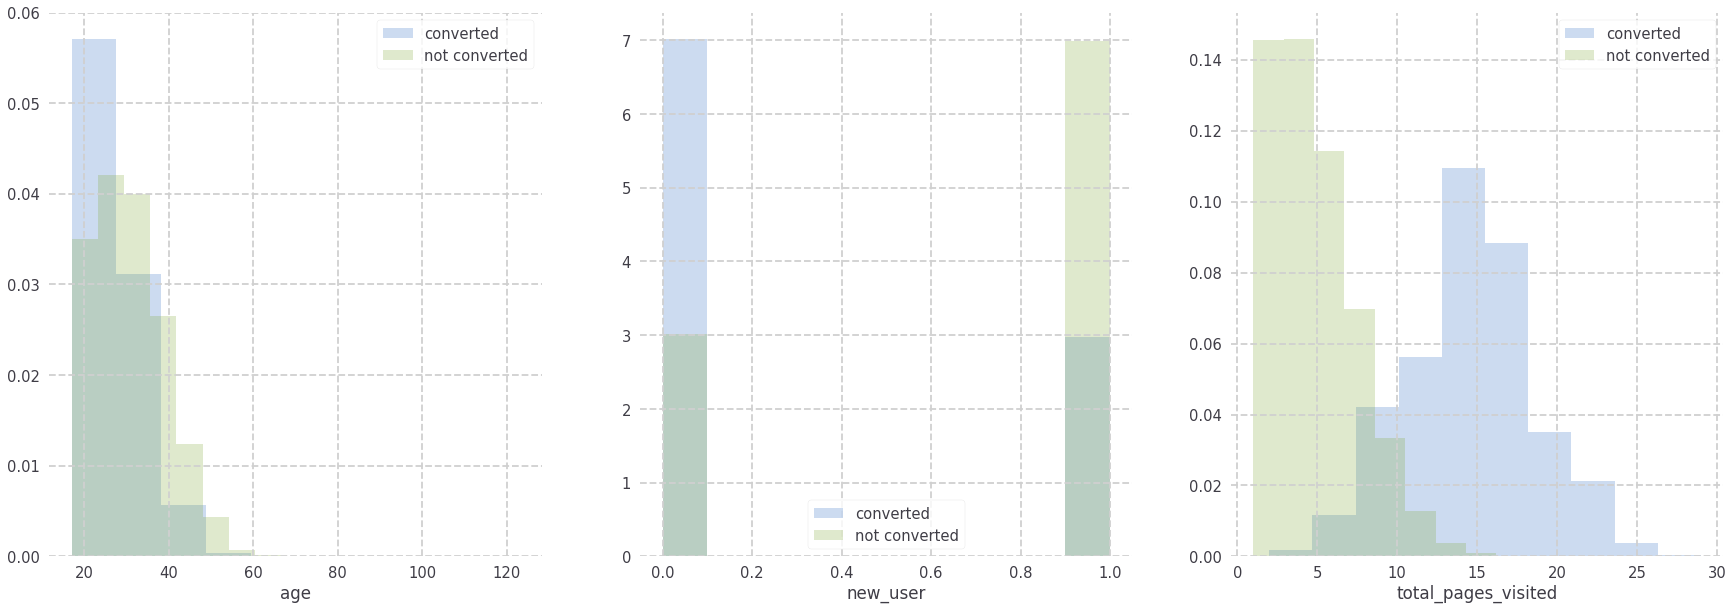

In [4]:
# Histograms of the numerical variables.
feature_names = ["age", "new_user", "total_pages_visited"]
converted_d_f = d_f[d_f["converted"] == 1]
nonconverted_d_f = d_f[d_f["converted"] == 0]
plt.gcf().clear()
axarr = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))[1]
for idx, feature in enumerate(feature_names):
    axarr[idx].hist(converted_d_f[feature].values, normed=1, label="converted", alpha=0.25)
    axarr[idx].hist(nonconverted_d_f[feature].values, normed=1, label="not converted", alpha=0.25)
    axarr[idx].set_xlabel(feature)
    axarr[idx].legend()
plt.show()

Users in UK 48450
Users in US 178092
Users in China 76602
Users in Germany 13056
['UK', 'US', 'China', 'Germany']


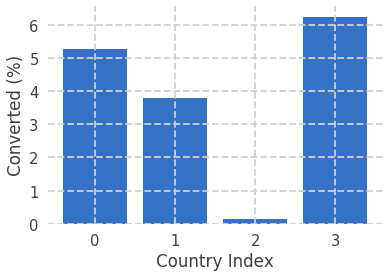

In [5]:
# Looking at proportion of converted users by country.
labels = []
proportions = []
for country in d_f["country"].unique():
    print("Users in " + country + " " + str(len(d_f[d_f["country"] == country])))
    labels.append(country)
    proportion = len(converted_d_f[converted_d_f["country"] == country]) / len(d_f[d_f["country"] == country]) * 100
    proportions.append(proportion)
print(labels)
plt.bar(range(len(labels)), proportions)
plt.xlabel("Country Index")
plt.ylabel("Converted (%)")
plt.show()

Users in Ads 88740
Users in Seo 155040
Users in Direct 72420
['Ads', 'Seo', 'Direct']


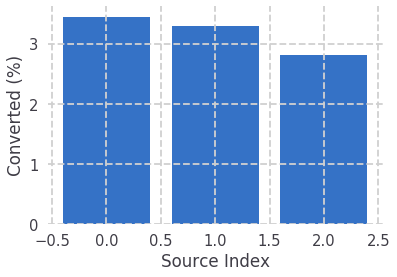

In [6]:
# Looking at proportion of converted users by source.
labels = []
proportions = []
for source in d_f["source"].unique():
    print("Users in " + source + " " + str(len(d_f[d_f["source"] == source])))
    labels.append(source)
    proportion = len(converted_d_f[converted_d_f["source"] == source]) / len(d_f[d_f["source"] == source]) * 100
    proportions.append(proportion)
print(labels)
plt.xlabel("Source Index")
plt.ylabel("Converted (%)")
plt.bar(range(len(labels)), proportions)
plt.show()

A few preliminary notes from the EDA:
1. Conversion is clearly more likely if a user visits more pages.
2. New users buy less often than returning users.
3. Almost nobody from China converts despite a substantial number of users from China.
4. Considered on the scale of the whole data set, source doesn't seem to matter much.

Generally the plan is to one-hot encode the categorical features, do a test-train split, some cross validation, and use either decision trees or logistic regression to predict the 1's and 0's in the test data, which we can then divide to get a conversion rate. The feature importance or coefficients will tell us which features are most important, and we can use these as "highest payoff" recommendations.  Let's try to get everything ready to go.

In [13]:
onehot_df = pd.get_dummies(data=d_f, columns=["country", "source"])
classifier_features = onehot_df[['age', 'new_user', 'total_pages_visited', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']]
classifier_target = onehot_df['converted']

In [14]:
from sklearn import tree
employee_clf = tree.DecisionTreeClassifier()
employee_clf = employee_clf.fit(classifier_features, classifier_target)

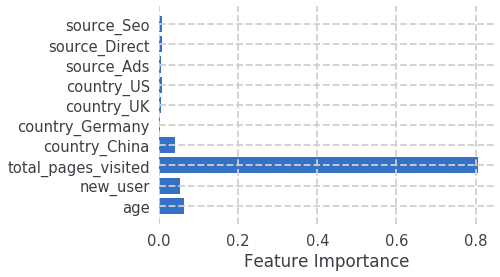

In [15]:
feature_labels = []
feature_importances = []
for name, importance in zip(classifier_features.columns, employee_clf.feature_importances_):
    feature_labels.append(name)
    feature_importances.append(importance)
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), feature_labels)
plt.xlabel("Feature Importance")
plt.show()

We can see that total pages visited is clearly the most important factor in determining whether a user converts. But what is driving people to visit more pages?

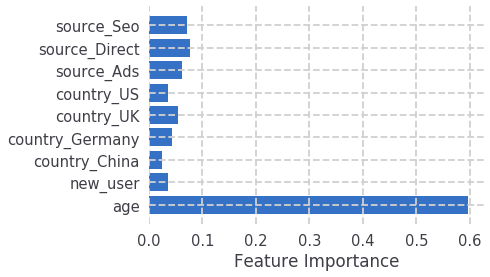

In [16]:
onehot_df = pd.get_dummies(data=d_f, columns=["country", "source"])
classifier_features = onehot_df[['age', 'new_user', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']]
classifier_target = onehot_df['total_pages_visited']
employee_clf = tree.DecisionTreeClassifier()
employee_clf = employee_clf.fit(classifier_features, classifier_target)
feature_labels = []
feature_importances = []
for name, importance in zip(classifier_features.columns, employee_clf.feature_importances_):
    feature_labels.append(name)
    feature_importances.append(importance)
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), feature_labels)
plt.xlabel("Feature Importance")
plt.show()

We can see that age matters the most in the number of pages visited.  This suggests there is some correlation in our variables (age and total pages visited are related and have an impact on conversion), so I'm going to shy away from using a Naive Bayes classifier, which doesn't learn anything about variable correlations. To try to predict conversion rates, I'll fit a logistic regression model to the data.

In [19]:
X = onehot_df[['age', 'new_user', 'total_pages_visited', 'country_China', 'country_Germany', 'country_UK', 'country_US', 'source_Ads', 'source_Direct', 'source_Seo']]
y = onehot_df['converted']

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [117]:
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

How does our model perform?

In [118]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.986748893106
0.987603365607


             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61232
          1       0.86      0.70      0.77      2008

avg / total       0.99      0.99      0.99     63240

Confusion matrix, without normalization
[[61004   228]
 [  610  1398]]


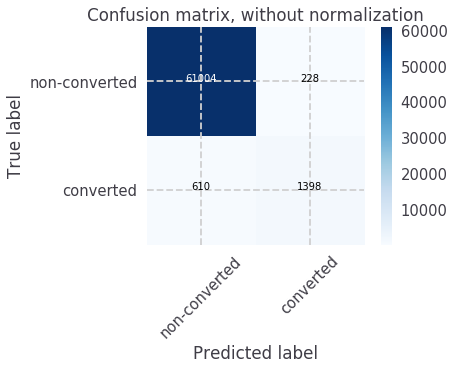

In [119]:
cnf_matrix = metrics.confusion_matrix(y_test, predicted)
print(metrics.classification_report(y_test, predicted))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cnf_matrix, classes=['non-converted', 'converted'],
                      title='Confusion matrix, without normalization')
plt.show()

In [83]:
# evaluate the model using 10-fold cross-validation
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.98719165  0.98545225  0.98636939  0.98545225  0.98681214  0.98526249
  0.98681214  0.98567362  0.98608476  0.98652751]
0.986163820367


Although the accuracy, precision, and recall are not too bad (86% precision and 68% recall for the "converted" class), there are still tons of false positives (we predict a conversion but they didn't convert) as evidenced by the confusion matrix.  Most likely this is the result of highly unbalanced data (~95% of people don't convert).  Introducing class weighting to the logistic regression model improves the recall to 93% but comes at the expense of terrible precision, which drops to 36%. It may be that a different classifier (like a decision tree, which can learn rules in the minority class) is more appropriate to do these predictions, and it would be appropriate to explore other models in future work.

In [101]:
coeff_df = pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_[0]))))
coeff_df.columns = ['x', 'y']
coeff_df.head()

,x,y
0,age,-0.073150
1,new_user,-1.730498
2,total_pages_visited,0.755617
3,country_China,-3.794625
4,country_Germany,-0.085267


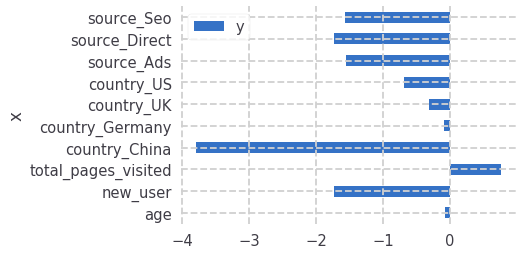

In [107]:
coeff_df.plot(x='x', y='y', kind='barh')
plt.show()

## Conclusions ##
* Logistic regression can predict conversion based on this data, albeit imperfectly.
* The Chinese market currently represents a lost cause - the company should either pull out of China to save money or re-think their marketing approach in this region.
* Getting users to come back and stay on the site for a long time is key.  A few ideas emerge:
    * Users buy significantly less frequently on their first visit. Offer e-mail incentives and reminders to return to the page.
    * Improving user engagement (as measure here by total_pages_visited) is probably a very high-payoff activity.
* The source of the referral (SEO vs. direct vs. ads) doesn't seem to matter too much.  While direct visits are probably hard to influence, if SEO vs. ads are more expensive per click, the company could focus on whichever one is cheaper to save money.